## Reproductible fitting 

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from jmstate import MultiStateJointModel
from jmstate.utils import *
from jmstate.functions import weibull

from uniformbands import get_bands

torch.manual_seed(0)

In [ ]:
def sigmoid(t, x, psi):
    a = psi[:, [0]]
    b = psi[:, [1]]
    c = psi[:, [2]]

    res = a * torch.sigmoid(b * (t - c))
    return res[:, :, None] 


def f(gamma, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [ ]:
##############################################

lmda = 6
k = 2

gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.tensor([1.0, 0.1, 1.0])
Q_repr = -0.5 * torch.log(Q)
R = torch.tensor([1.1])
R_repr = -0.5 * torch.log(R)

alphas = {
    (0, 1): torch.tensor([1.7]),
}
betas = {
    (0, 1): torch.tensor([-1.34, 2.5, 3.2]),
}

real_params = ModelParams(gamma, (Q_repr, "diag"), (R_repr, "ball"), alphas, betas)

In [ ]:
weibull_fn = weibull(k, lmda)

surv = {
    (0, 1): (weibull_fn, sigmoid),
}

In [ ]:
model_design = ModelDesign(f, sigmoid, surv)

In [ ]:
real_model = MultiStateJointModel(model_design, real_params, n_quad=128)

n, p = 500, 3

# Generate training set
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)
b = torch.randn(n, real_params.gamma.shape[0]) * torch.sqrt(Q)
psi = f(real_params.gamma, b)

In [ ]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)

In [ ]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 1
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

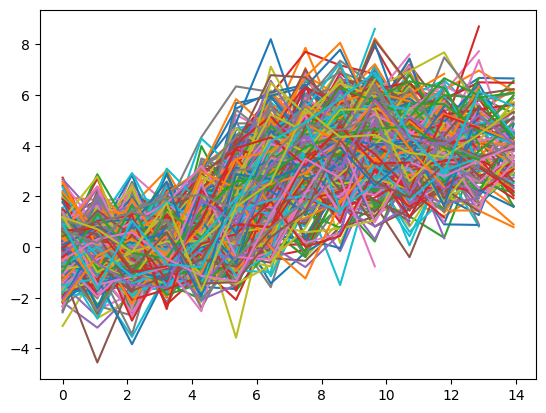

In [ ]:
y = model_design.h(t, x, psi)
y += torch.randn_like(y) * torch.sqrt(R)
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan
plt.plot(t, y.squeeze(-1).T)
plt.show()

In [ ]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(Q_repr), "diag"),
    (torch.zeros_like(R_repr), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

In [ ]:
data = ModelData(x, t, y, trajectories, c)

In [ ]:
buckets = build_buckets(trajectories)
print([(key, buckets[key][0].numel()) for key in buckets.keys()])

[((0, 1), 479)]


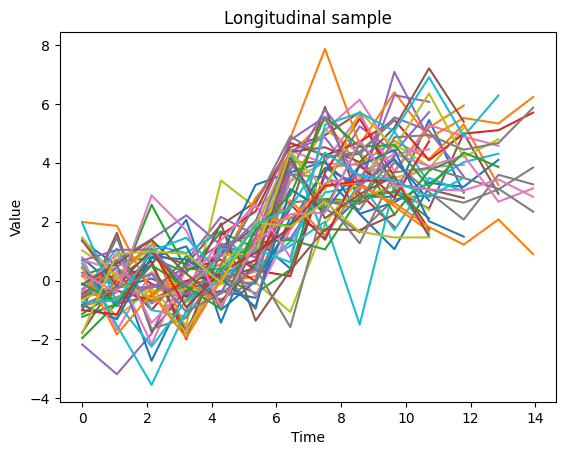

In [ ]:
plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [ ]:
history = []

callback = lambda model, sampler: history.append([p.detach().clone() for p in model.params_.as_list])

model = MultiStateJointModel(model_design, init_params, enable_likelihood_cache=True, enable_predict_cache=True)
model.fit(data, callback=callback, n_iter=3000, cont_warmup=0)

Fitting joint model: 100%|██████████| 3000/3000 [00:07<00:00, 398.98it/s]


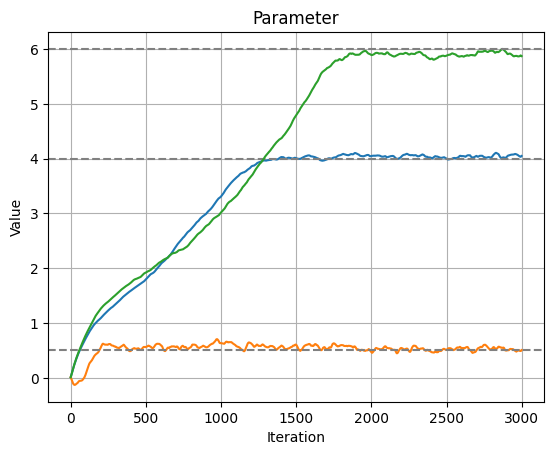

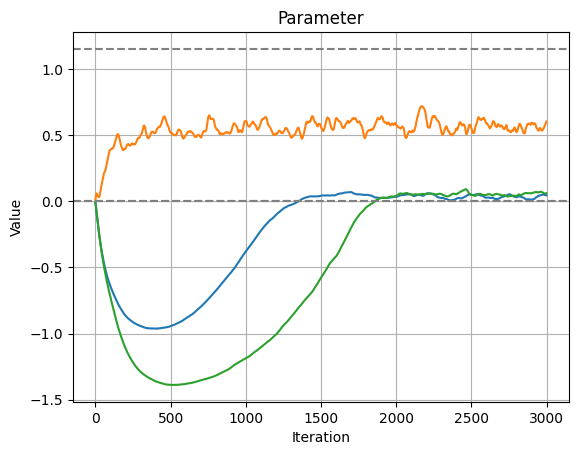

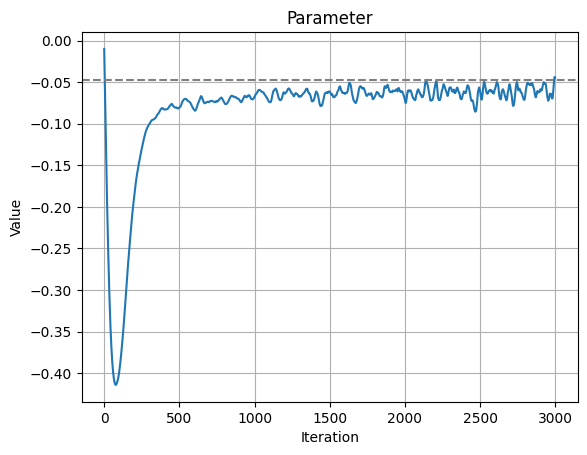

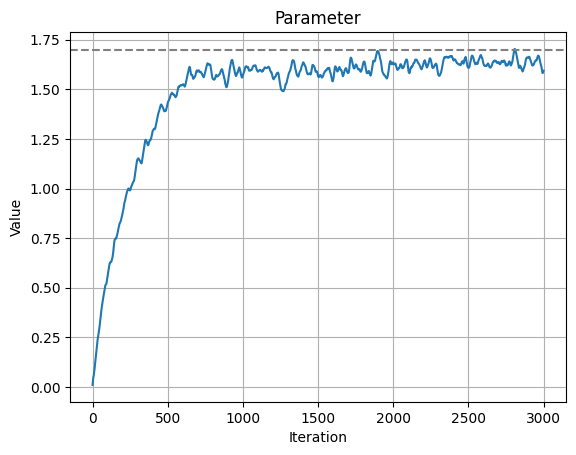

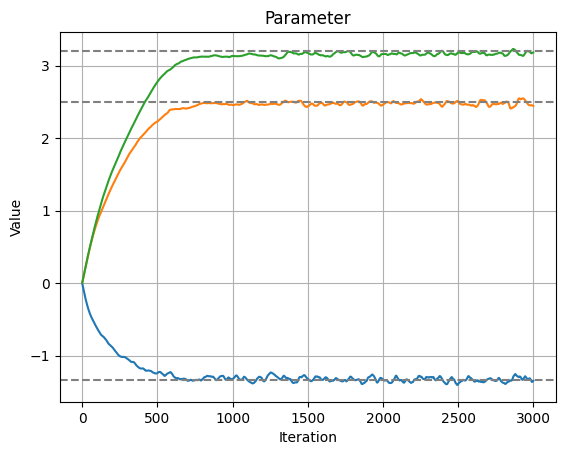

In [ ]:
real_params_list = real_params.as_list

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])
        plt.axhline(y=float(real_params_list[i][j]), linestyle="--", color="gray")

    plt.title(f"Parameter")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [ ]:
print("Estimation")
print(model.params_)

Estimation
ModelParams(gamma=tensor([4.0650, 0.5367, 5.8817], requires_grad=True), Q_repr=(tensor([0.0492, 0.5114, 0.0464], requires_grad=True), 'diag'), R_repr=(tensor([-0.0520], requires_grad=True), 'ball'), alphas={(0, 1): tensor([1.6315], requires_grad=True)}, betas={(0, 1): tensor([-1.3445,  2.4950,  3.2000], requires_grad=True)})


In [ ]:
# Generate test individual

torch.manual_seed(12345)

n_test = 1

# Generate training set
c_test = torch.rand(n_test) * 5 + 10
x_test = torch.randn(n_test, p)
b_test = torch.randn(n_test, real_params.gamma.shape[0]) * torch.sqrt(Q)
psi_test = f(real_params.gamma, b_test)

trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

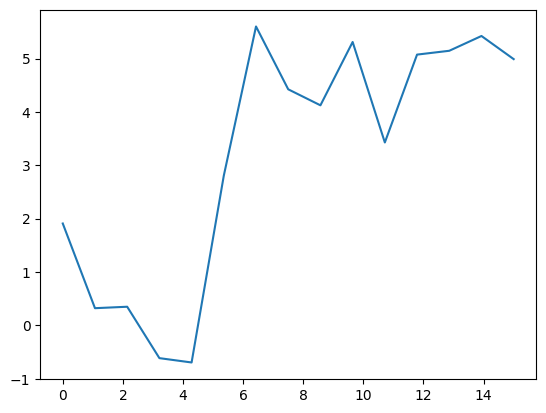

In [ ]:
y_test = model_design.h(t, x_test, psi_test)
y_test += torch.randn_like(y_test) * torch.sqrt(R)
plt.plot(t, y_test.squeeze(-1).T)
plt.show()

In [ ]:
log_probs = []

prediction_times = torch.linspace(2.0, 6.0, 5)

for time in prediction_times:
    c_test = torch.full((n_test,), time)
    
    sample_test_data = SampleData(
        x_test,
        trajectories_init_test,
        psi_test,
        c_test,
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs.append(real_model.compute_surv_log_probs(sample_test_data, u))

In [ ]:

log_probs_pred = []

for time in prediction_times:
    c_test = torch.full((n_test,), time)

    pred_test_data = ModelData(
        x_test,
        t[t <= time],
        y_test[:, t <= time, :],
        trajectories_init_test,
        c_test
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs_pred.append(model.predict_surv_log_probs(pred_test_data, u, n_iter_b=1000))


Predicting survival log probabilities:  69%|██████▉   | 693/1000 [00:08<00:03, 84.31it/s]


KeyboardInterrupt: 

In [ ]:
vals = [key[2] for key in model._cache["base"].keys()]
unique_count = len(set(vals))
print(f"Number of unique values: {unique_count}")

[-7696270115748315862, -2737982707846548475, -2009959932861218432, 8248808159445971552, -8436362472931158490, -8575171468210422800, -1213224587672350409, -3248345397588235866, 2558711674915614812, -8813418637555591397, -6252908193084234995, -638904750624668614, 909109790447025188, 5947710652895439492, 1530242322779219471, -891868957364174851, 3662933577070227962, 2733678224153286715, 4653185727001866477, -8247929232038782330, 4878617285325824735, 7880248775623461676, -3233505037571188641, 1858265003570841597, 7865568728034343118, 922012539948207696, -8398824186310234175, -549029277655115987, -5061129056833382993, -462303835718343302, 5113186483708115627, 6286098488432300315, 3220792143827941646, 1587737964006343862, -3867632161133167490, -6915300378459047987, -1342986720265446461, 4796820466038767093, -7248864438176636064, 4093142749650207020, -698920171792640870, 971777736655183262, -803207608713285671, 1537757519160796502, 2050469174631971476, -1206397274511736508, 212114087621368856

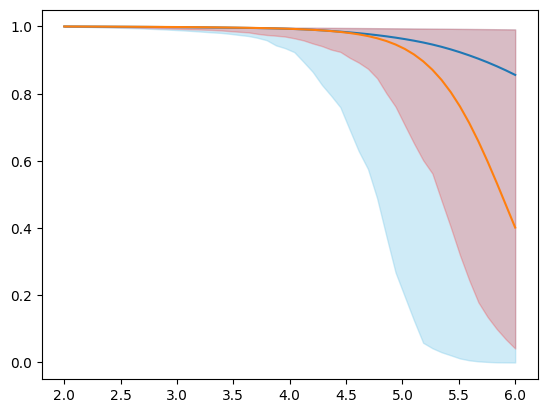

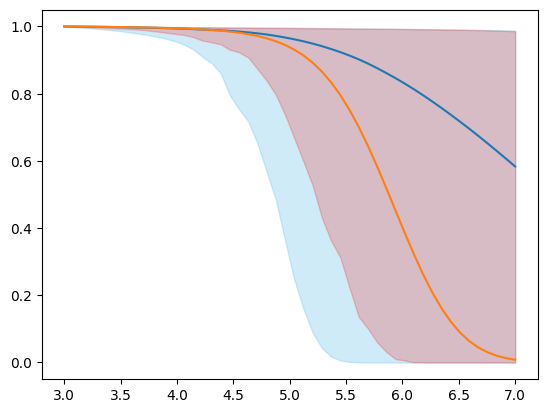

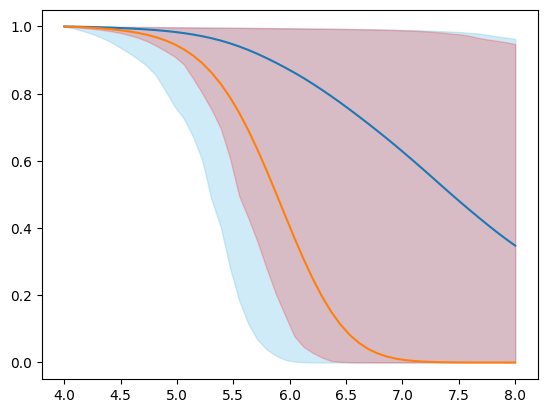

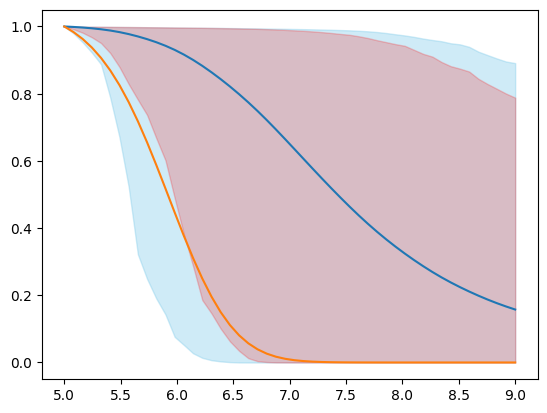

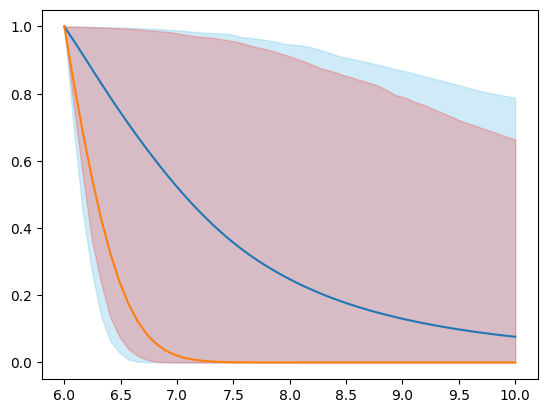

In [ ]:
for i, (lp, lpp) in enumerate(zip(log_probs, log_probs_pred)):
    probs_pred = torch.vstack([torch.exp(lpp[i][0].detach()) for i in range(len(lpp))]).numpy()

    bands = get_bands(probs_pred)
    pointwise = np.quantile(probs_pred, [0.025, 0.975], axis=0)

    points = prediction_times[i] + torch.linspace(0, 4, 50)

    plt.plot(points, probs_pred.mean(axis=0))
    plt.fill_between(points, bands["lower"], bands["upper"], 
                    color='skyblue',                         
                    alpha=0.4)
    plt.fill_between(points, pointwise[0], pointwise[1], 
                    color='red',                          
                    alpha=0.2)
    plt.plot(points, torch.exp(lp[0]).numpy())
    plt.show()